In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
import matplotlib.pyplot as plt
dob = dobbellogger()

In [246]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [247]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

gyro_bias = [-0.10488443, 0.48133019, -0.05951701]
acc_bias = [0.00462698, 0.02152201, -0.04949736]

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [248]:
data.head()

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.016836,-0.042396,-0.999820,-0.152396,-0.054501,0.086558
1,20.0,0.017590,-0.044105,-0.998423,-0.323916,0.189402,0.104586
2,31.0,0.014215,-0.043861,-0.995031,-0.057622,-0.054501,0.163305
3,41.0,0.012828,-0.041786,-0.995840,-0.028263,-0.054501,0.030158
4,50.0,0.011210,-0.042762,-0.996364,-0.084663,-0.054501,-0.093976


In [249]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]

In [250]:
q11 = max_eigenvector

In [251]:
print(rotate_vector(np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]]), q11))

[8.41826047e-03 1.38777878e-17 1.00082429e+00]


In [252]:
q = np.reshape(q11, 4)
q_list = [q]


for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    q_list.append(q)

    

In [253]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

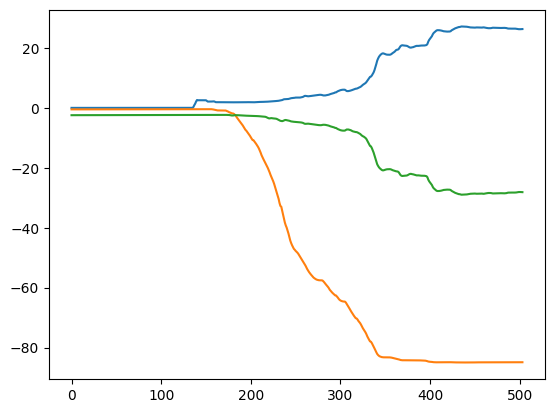

In [254]:
plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [190]:
def Somega(omega):
    x, y, z = np.reshape(omega, 3)
    out = np.array([
        [0,-x,-y,-z],
        [x,0,x,-y],
        [y,-z,0,x],
        [z,y,-x,0]
    ])
    return out

def Sq(q):
    q0, q1, q2, q3 = np.reshape(q, 4)
    out = np.array([
        [-q1,-q2,-q3],
        [q0,-q3,q2],
        [q3,q0,-q1],
        [-q2,q1,q0]
    ])
    return out

In [191]:
q = np.reshape(q11, (4, 1))
q_list = [q]
I4 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1]
])

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    omega = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]]) * np.pi / 180
    q = np.matmul(I4 + 0.5 * Somega(omega) * dt, q) + 0.5 * dt * np.matmul(Sq(q), np.reshape(omega, (3, 1)))
    q = np.reshape(q, (4, 1))
    q_list.append(q)

    

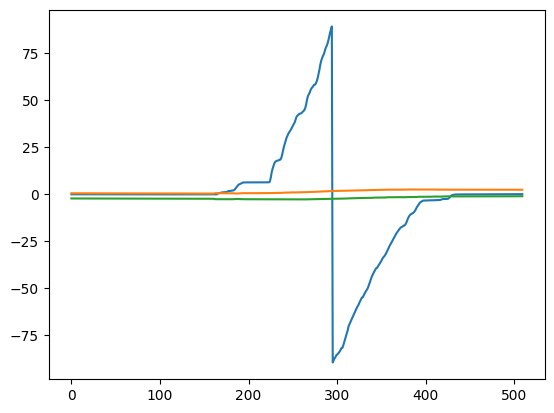

In [192]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    q = np.reshape(q, 4)
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)
plt.show()